In [2]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nostress.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

In [41]:
vars_025deg = cc.querying.get_variables(session, experiment=expt[0])
vars_025deg[vars_025deg['name'].str.lower().str.match('frazil')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
32,frazil,frazil ice growth,1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
33,frazil_3d_int_z,Vertical sum of ocn frazil heat flux over time...,1 daily,output007/ocean/ocean-2d-frazil_3d_int_z-1-dai...,2,1914-01-01 00:00:00,1916-01-01 00:00:00
153,frazil_3d_int_z,Vertical sum of ocn frazil heat flux over time...,1 monthly,output009/ocean/ocean-2d-frazil_3d_int_z-1-mon...,20,1900-01-01 00:00:00,1920-01-01 00:00:00
154,frazil_m,frazil ice growth,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00


In [ ]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer(session=session)
dbx

## 1. Seasonal vertical profiles of velocity shear in Weddell gyre

In [16]:
u_con = cc.querying.getvar(expt[0],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-60,40)).sel(yu_ocean = slice(-80,-55))
v_con = cc.querying.getvar(expt[0],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-60,40)).sel(yu_ocean = slice(-80,-55))
u_buo = cc.querying.getvar(expt[1],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-60,40)).sel(yu_ocean = slice(-80,-55))
v_buo = cc.querying.getvar(expt[1],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-60,40)).sel(yu_ocean = slice(-80,-55))

In [17]:
area = cc.querying.getvar(expt='025deg_jra55_ryf_nostress', variable='area_u', session=session, frequency='static', n=1).sel(
    xu_ocean = slice(-60,40)).sel(yu_ocean = slice(-80,-55))
u_avg_con = (u_con*area).sum(dim = ['xu_ocean','yu_ocean'])/area.sum(dim = ['xu_ocean','yu_ocean'])
u_avg_buo = (u_buo*area).sum(dim = ['xu_ocean','yu_ocean'])/area.sum(dim = ['xu_ocean','yu_ocean'])
v_avg_con = (v_con*area).sum(dim = ['xu_ocean','yu_ocean'])/area.sum(dim = ['xu_ocean','yu_ocean'])
v_avg_buo = (v_buo*area).sum(dim = ['xu_ocean','yu_ocean'])/area.sum(dim = ['xu_ocean','yu_ocean'])

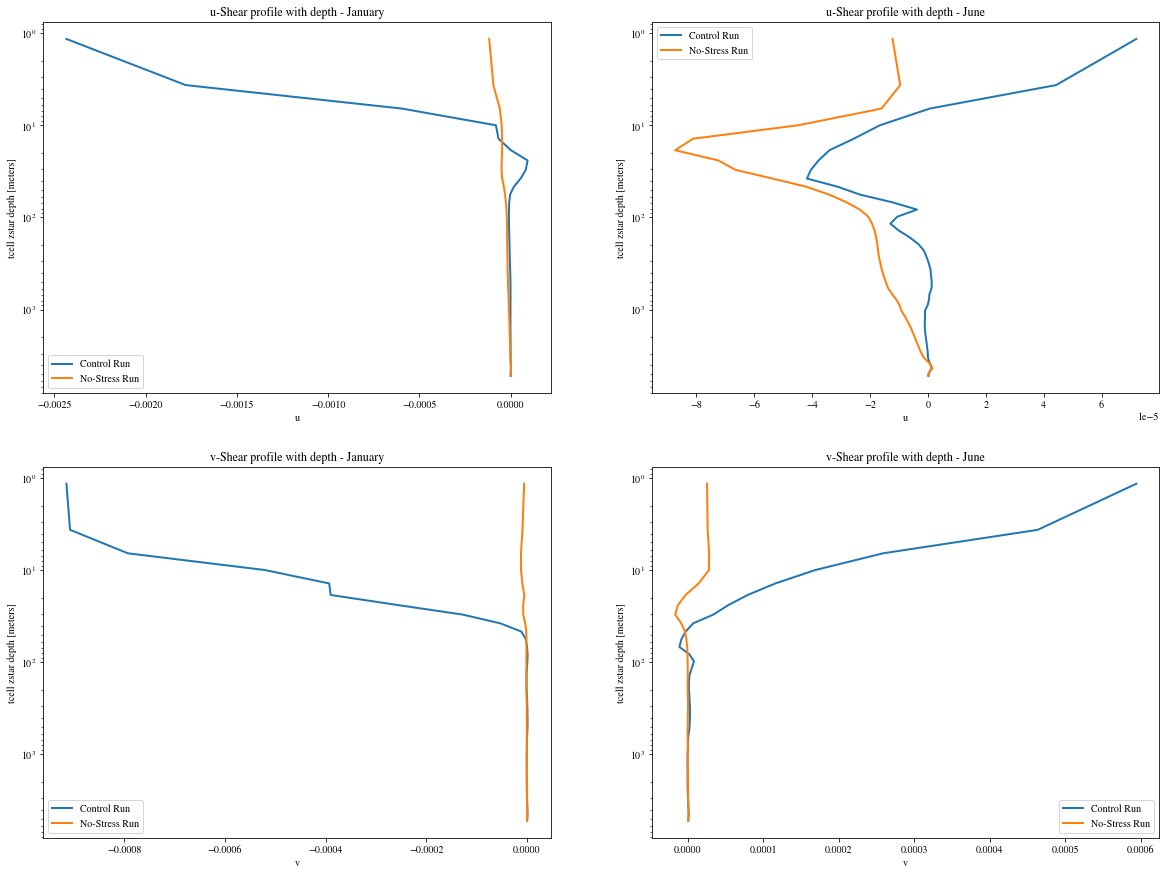

In [48]:
ushear_con = u_con.sel(time = slice('1919-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
ushear_buo = u_buo.sel(time = slice('1919-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_con = v_con.sel(time = slice('1919-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_buo = v_buo.sel(time = slice('1919-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
axes[0][0].invert_yaxis()
axes[0][0].set_yscale("log")
ushear_con.sel(time = slice('1919-01-01','1919-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='Control Run')
ushear_buo.sel(time = slice('1919-01-01','1919-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='No-Stress Run')
axes[0][0].set_title('u-Shear profile with depth - January')
axes[0][0].legend()

axes[0][1].invert_yaxis()
axes[0][1].set_yscale("log")
ushear_con.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='Control Run')
ushear_buo.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='No-Stress Run')
axes[0][1].set_title('u-Shear profile with depth - June')
axes[0][1].legend()

axes[1][0].invert_yaxis()
axes[1][0].set_yscale("log")
vshear_con.sel(time = slice('1919-01-01','1919-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='Control Run')
vshear_buo.sel(time = slice('1919-01-01','1919-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='No-Stress Run')
axes[1][0].set_title('v-Shear profile with depth - January')
axes[1][0].legend()

axes[1][1].invert_yaxis()
axes[1][1].set_yscale("log")
vshear_con.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='Control Run')
vshear_buo.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='No-Stress Run')
axes[1][1].set_title('v-Shear profile with depth - June')
axes[1][1].legend()

## 2. Seasonal sea ice concentration in Weddell gyre

In [11]:
variable='aice_m'
aice_con = cc.querying.getvar(expt[0], variable, session, frequency='1 monthly', start_time='1901-01-01', end_time='1919-12-31',decode_coords=False)
aice_buo = cc.querying.getvar(expt[1], variable, session, frequency='1 monthly', start_time='1901-01-01', end_time='1919-12-31',decode_coords=False)
area_t = cc.querying.getvar(expt='025deg_jra55_ryf_nostress', variable='area_t', session=session, frequency='static', n=1)

aice_con.coords['ni'] = area_t['xt_ocean'].values
aice_con.coords['nj'] = area_t['yt_ocean'].values
aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_buo.coords['ni'] = area_t['xt_ocean'].values
aice_buo.coords['nj'] = area_t['yt_ocean'].values
aice_buo = aice_buo.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

area_con = aice_con*area_t
area_buo = aice_buo*area_t

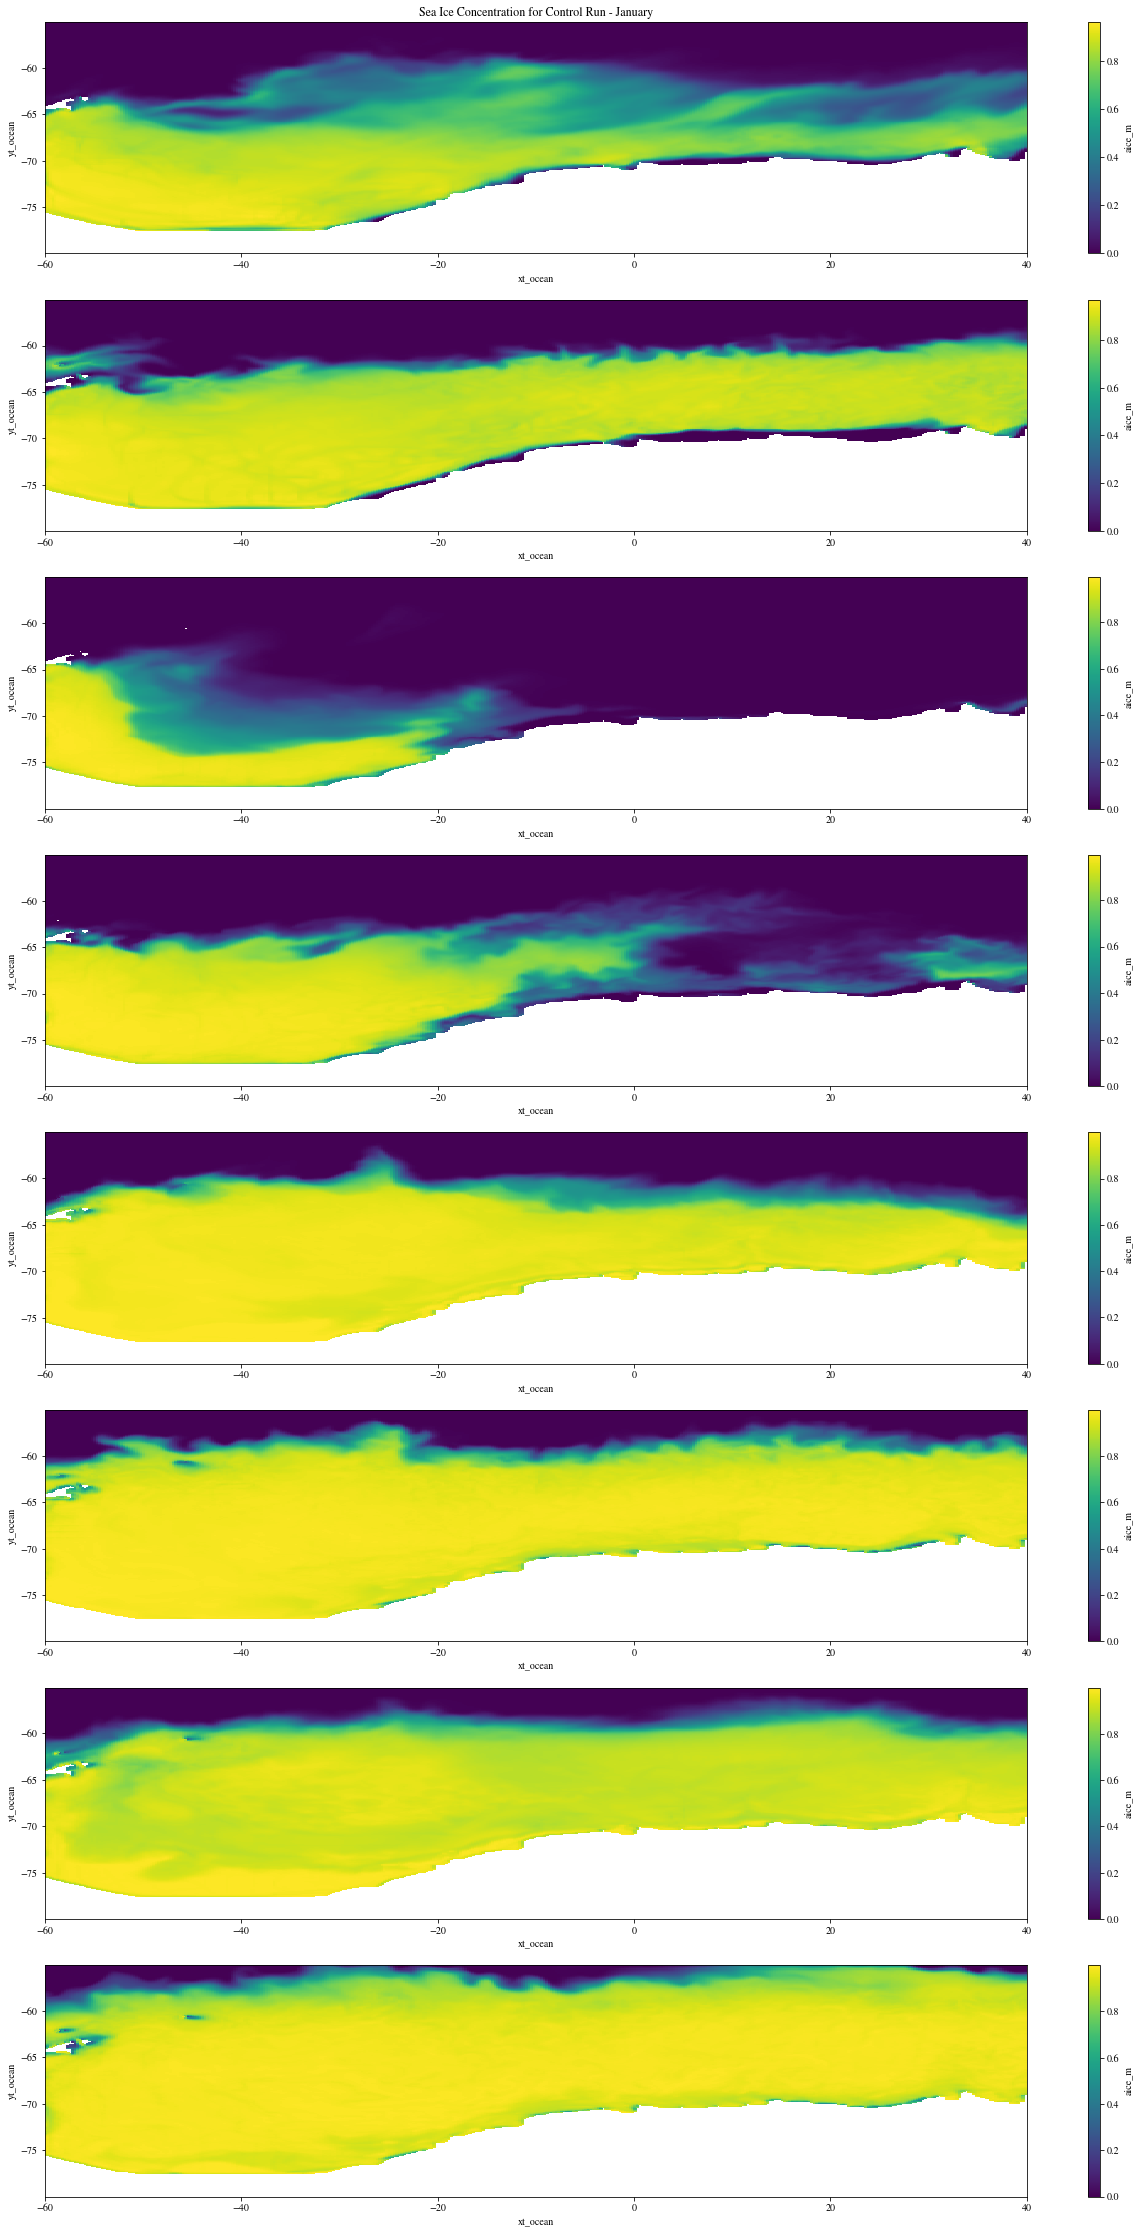

In [21]:
plt.figure(figsize=(22,40))

plt.subplot(811)
aice_con.sel(time = slice('1919-01-01','1919-01-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Control Run - January')

plt.subplot(812)
aice_buo.sel(time = slice('1919-01-01','1919-01-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Buoyancy Run - January')

plt.subplot(813)
aice_con.sel(time = slice('1919-04-01','1919-04-30')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Control Run - April')

plt.subplot(814)
aice_buo.sel(time = slice('1919-04-01','1919-04-30')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Buoyancy Run - April')

plt.subplot(815)
aice_con.sel(time = slice('1919-07-01','1919-07-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Control Run - July')

plt.subplot(816)
aice_buo.sel(time = slice('1919-07-01','1919-07-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Buoyancy Run - July')

plt.subplot(817)
aice_con.sel(time = slice('1919-10-01','1919-10-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Control Run - October')

plt.subplot(818)
aice_buo.sel(time = slice('1919-10-01','1919-10-31')).mean('time').sel(xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55)).plot()
plt.title('Sea Ice Concentration for Buoyancy Run - October')

plt.show()

## 3. Time series of surface heat flux due to coupler, mass flux and sea ice growth

In [27]:
Qnet_con = cc.querying.getvar(expt=expt[0], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31').sel(
    xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55))
Qnet_buo = cc.querying.getvar(expt=expt[1], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31').sel(
    xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55))
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1).sel(
    xt_ocean = slice(-60,40)).sel(yt_ocean = slice(-80,-55))

In [30]:
Qnet_avg_con = (Qnet_con*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])
Qnet_avg_buo = (Qnet_buo*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(111)
Qnet_avg_con.plot()
Qnet_avg_buo.plot()
plt.title('Time series of the mean surface heat flux in Weddell Gyre due to coupler and mass flux')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

In [49]:
variable='frazil_m'
frazil_con = cc.querying.getvar(expt[0], variable, session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31',decode_coords=False)
frazil_buo = cc.querying.getvar(expt[1], variable, session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31',decode_coords=False)
area_t = cc.querying.getvar(expt='025deg_jra55_ryf_nostress', variable='area_t', session=session, frequency='static', n=1)

frazil_con.coords['ni'] = area_t['xt_ocean'].values
frazil_con.coords['nj'] = area_t['yt_ocean'].values
frazil_con = frazil_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

frazil_buo.coords['ni'] = area_t['xt_ocean'].values
frazil_buo.coords['nj'] = area_t['yt_ocean'].values
frazil_buo = frazil_buo.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [50]:
frazil_avg_con = (frazil_con*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])
frazil_avg_buo = (frazil_buo*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(111)
frazil_avg_con.plot()
frazil_avg_buo.plot()
plt.title('Time series of the mean surface heat flux in Weddell Gyre due to ice growth')
plt.legend(['Control Run','No-stress Run']) 
plt.show()